In [65]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_dataset, Dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd
import nltk

In [63]:
def load_jsonl_data(file_path):
    data = pd.read_json(file_path, lines=True)
    return data

matched_data = load_jsonl_data('/home/mfuai/MSBD5018/dev_matched_sampled-1.jsonl')
mismatched_data = load_jsonl_data('/home/mfuai/MSBD5018/dev_mismatched_sampled-1.jsonl')

nli_data = pd.concat([matched_data, mismatched_data])
nli_data = nli_data.sample(frac=1, random_state=42).reset_index(drop=True)
nli_data = nli_data[nli_data['gold_label'].isin(['contradiction', 'entailment', 'neutral'])]
nli_dataset = Dataset.from_pandas(nli_data)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def preprocess_function(examples):
    label_map = {"contradiction": 0, "entailment": 1, "neutral": 2, "-": -1}
    encoding = tokenizer(
        examples['sentence1'],
        examples['sentence2'],
        truncation=True,
        padding='max_length',
        max_length=512
    )
    
    labels = [label_map.get(label, -1) for label in examples['gold_label']]
    encoding['label'] = labels
    return encoding


encoded_nli_dataset = nli_dataset.map(preprocess_function, batched=True)
train_size = int(0.9 * len(encoded_nli_dataset))
nli_train_dataset = encoded_nli_dataset.select(range(train_size))
nli_eval_dataset = encoded_nli_dataset.select(range(train_size, len(encoded_nli_dataset)))


Map: 100%|██████████| 4924/4924 [00:01<00:00, 3201.36 examples/s]


In [62]:
sample = nli_eval_dataset[1]
print("Sentence 1:", sample['sentence1'])
print("Sentence 2:", sample['sentence2'])
print("Gold Label:", sample['gold_label'])
print("Label:", sample['labels'])

Sentence 1: Eventually, the shelter received word that the alleged hijacker 5 miles away had been a medevac helicopter.
Sentence 2: The shelter acted against the hijacked medevac helicopter.
Gold Label: neutral
Label: 2


In [66]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    accuracy = accuracy_score(p.label_ids, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [67]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

training_args = TrainingArguments(
    output_dir="./roberta_results",
    num_train_epochs=10,  # 减少训练轮数以防止过拟合
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=2e-5,
    metric_for_best_model="accuracy", 
    greater_is_better=True,           
    warmup_steps=100,
    lr_scheduler_type="cosine",
    fp16=True  # 启用混合精度训练
)


loss_values = []
accuracy_values = []

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")  # 获取标签
        outputs = model(**inputs)  # 前向传播
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss()  # 交叉熵损失
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

    def log(self, logs):
        # 在每次记录日志时将训练损失记录到 loss_values 中
        if 'loss' in logs:
            loss_values.append(logs['loss'])
        # 记录评估的准确率
        if 'eval_accuracy' in logs:
            accuracy_values.append(logs['eval_accuracy'])
        super().log(logs)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=nli_train_dataset,
    eval_dataset=nli_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] 
)

# 开始训练
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mfuai/.conda/envs/msbd5018/lib/python3.9/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /opt/conda/conda-bld/pytorch_1728945380152/work/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.917200,0.797234,0.667343,0.709635,0.667343,0.667511
2,0.668600,0.577756,0.797160,0.803046,0.797160,0.787073
3,0.456700,0.472845,0.827586,0.829717,0.827586,0.825206
4,0.276900,0.525262,0.845842,0.845824,0.845842,0.844528
5,0.079600,0.594664,0.851927,0.851355,0.851927,0.851040
6,0.072200,0.734099,0.845842,0.849294,0.845842,0.845802
7,0.027600,0.785856,0.855984,0.860030,0.855984,0.856469
8,0.015000,0.844240,0.853955,0.860434,0.853955,0.853674
9,0.034500,0.849846,0.862069,0.866233,0.862069,0.861789
10,0.016100,0.846319,0.862069,0.866233,0.862069,0.861789


/home/mfuai/.conda/envs/msbd5018/lib/python3.9/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /opt/conda/conda-bld/pytorch_1728945380152/work/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/mfuai/.conda/envs/msbd5018/lib/python3.9/site-packages/torch/autograd/graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at /opt/conda/conda-bld/pytorch_1728945380152/work/aten/src/ATen/native/cudnn/MHA.cpp:674.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/mfuai/.conda/envs/msbd5018/lib/python3.9/site-packages/torch/autograd/graph.py:825: User

TrainOutput(global_step=1390, training_loss=0.2651017622914996, metrics={'train_runtime': 167.7644, 'train_samples_per_second': 264.12, 'train_steps_per_second': 8.285, 'total_flos': 1.165855553952768e+16, 'train_loss': 0.2651017622914996, 'epoch': 10.0})

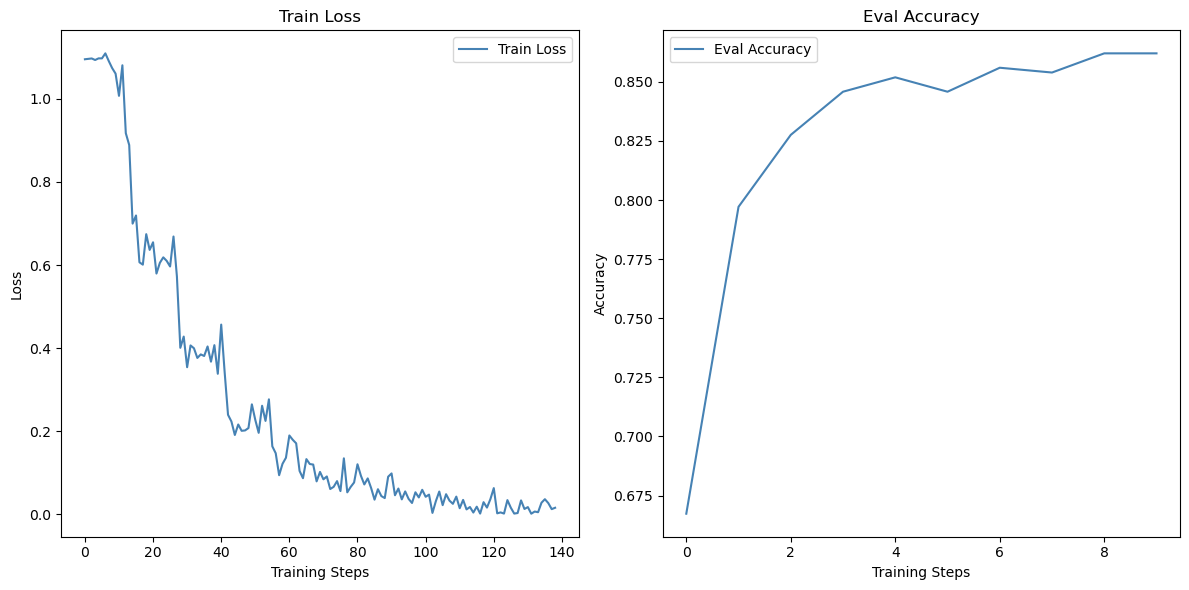

<Figure size 640x480 with 0 Axes>

In [68]:
# 创建一个图形，分为两列
plt.figure(figsize=(12, 6))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(loss_values, label="Train Loss", color="steelblue")
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label="Eval Accuracy", color="steelblue")
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Eval Accuracy')
plt.legend()


plt.tight_layout()
plt.show()
plt.savefig("training_curve.png")


In [69]:
trainer.save_model("./roberta_finetuned_model")
tokenizer.save_pretrained("./roberta_finetuned_model")

results = trainer.evaluate()
print("Evaluation results:", results)

Evaluation results: {'eval_loss': 0.8498455882072449, 'eval_accuracy': 0.8620689655172413, 'eval_precision': 0.8662330258798462, 'eval_recall': 0.8620689655172413, 'eval_f1': 0.8617887944556913, 'eval_runtime': 0.433, 'eval_samples_per_second': 1138.546, 'eval_steps_per_second': 36.951, 'epoch': 10.0}


In [70]:
tokenizer_ft = RobertaTokenizer.from_pretrained("./roberta_finetuned_model")
model_ft = RobertaForSequenceClassification.from_pretrained("./roberta_finetuned_model")
model_ft.to('cuda')

hal_dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")
hal_eval_dataset = hal_dataset['evaluation']

print(hal_eval_dataset)
print(hal_eval_dataset[0])


Dataset({
    features: ['gpt3_text', 'wiki_bio_text', 'gpt3_sentences', 'annotation', 'wiki_bio_test_idx', 'gpt3_text_samples'],
    num_rows: 238
})
{'gpt3_text': "John Russell Reynolds (1820–1876) was an English lawyer, judge, and author. He was born in London, the son of a barrister, and was educated at Eton College and Trinity College, Cambridge. He was called to the bar in 1845, and became a Queen's Counsel in 1859. He was appointed a judge of the Court of Common Pleas in 1867, and was knighted in 1871.\n\nReynolds was a prolific author, writing on a wide range of topics. He wrote several books on legal topics, including The Law of Libel and Slander (1863), The Law of Copyright (1865), and The Law of Patents for Inventions (1868). He also wrote on a variety of other topics, including history, biography, and literature. He was a frequent contributor to the Saturday Review, and wrote several books on Shakespeare, including The Mystery of William Shakespeare (1848) and The Authorshi

In [71]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/mfuai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/mfuai/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [72]:
# 标签转换：Non-Factual (1) 和 Factual (0)
def map_labels(label):
    if label in ['major_inaccurate', 'minor_inaccurate']:
        return 1  # Non-Factual
    elif label == 'accurate':
        return 0  # Factual
    return -1  # 处理未知标签的情况

# 获取所需字段
wiki_bio_texts = hal_eval_dataset['wiki_bio_text']
gpt3_sentences = hal_eval_dataset['gpt3_sentences']
annotations = hal_eval_dataset['annotation']

# 新建一个列表来存储处理后的数据
processed_data = []

for wiki_bio_text, gpt3_sentence_list, annotation_list in zip(wiki_bio_texts, gpt3_sentences, annotations):
    # 清理 wiki_bio_text，去除多余的空格或换行符
    wiki_bio_text = wiki_bio_text.replace('\n', ' ').strip()
    
    # 使用 nltk 分割 wiki_bio_text 为多个句子
    try:
        wiki_bio_sentences = nltk.sent_tokenize(wiki_bio_text)
    except Exception as e:
        print(f"Error processing text: {wiki_bio_text[:50]}... Error: {e}")
        continue  # 如果分割出错，跳过此行数据

    # 如果 wiki_bio_sentences 数量大于 gpt3_sentence_list，进行平均分配
    n_sentences = len(gpt3_sentence_list)
    if len(wiki_bio_sentences) > n_sentences:
        # 按块分配每个 gpt3_sentence 到对应的 wiki_bio_sentences
        sentences_per_gpt3 = len(wiki_bio_sentences) // n_sentences
        remainder = len(wiki_bio_sentences) % n_sentences
        
        for i in range(n_sentences):
            start_idx = i * sentences_per_gpt3 + min(i, remainder)
            end_idx = (i + 1) * sentences_per_gpt3 + min(i + 1, remainder)
            combined_wiki_sentences = ' '.join(wiki_bio_sentences[start_idx:end_idx]).strip()
            processed_data.append({
                'gpt3_sentence': gpt3_sentence_list[i].strip(),
                'wiki_bio_sentences': combined_wiki_sentences,
                'annotation': annotation_list[i].strip()
            })
    else:
        # 如果句子数相等，则直接一一对应
        for i, wiki_sentence in enumerate(wiki_bio_sentences):
            processed_data.append({
                'gpt3_sentence': gpt3_sentence_list[i].strip(),
                'wiki_bio_sentences': wiki_sentence.strip(),
                'annotation': annotation_list[i].strip()
            })


df_processed = pd.DataFrame(processed_data)
df_processed['label'] = df_processed['annotation'].apply(map_labels)

# 将 DataFrame 转换为 Hugging Face Dataset
processed_dataset = Dataset.from_pandas(df_processed)
print(processed_dataset[0])

{'gpt3_sentence': 'John Russell Reynolds (1820–1876) was an English lawyer, judge, and author.', 'wiki_bio_sentences': 'Sir John Russell Reynolds, 1st Baronet (22 May 1828 – 29 May 1896) was a British neurologist and physician. Reynolds was born in Romsey, Hampshire, as the son of John Reynolds, an independent minister, and the grandson of Dr. Henry Revell Reynolds. He received general education from his father, and was educated in his profession at University College, London, where he obtained three gold medals in the medical school. In 1851, he graduated M.B.', 'annotation': 'major_inaccurate', 'label': 1}


In [73]:
from tqdm import tqdm

# 创建评估所需的模型
model_ft.eval()

# 准备数据
premises = processed_dataset['wiki_bio_sentences']
hypotheses = processed_dataset['gpt3_sentence']
labels = processed_dataset['label']


# 存储模型的预测
predictions = []

# 逐句推理
for premise, hypothesis in tqdm(zip(premises, hypotheses), desc="Evaluating"):
    # 编码输入
    encoding = tokenizer_ft(
        premise,
        hypothesis,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=512
        ).to('cuda')
    
    with torch.no_grad():
        outputs = model_ft(**encoding)
    
    # 假设模型的输出是logits，我们用softmax将它转为概率
    logits = outputs.logits
    pred = torch.argmax(logits, dim=-1).item()
    if pred != 0:
        pred = 1
    predictions.append(pred)

# 计算评估指标
accuracy = accuracy_score(labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating: 1795it [00:07, 230.03it/s]

Accuracy: 0.6189
Precision: 0.7139
Recall: 0.7988
F1 Score: 0.7540


In [51]:
from tqdm import tqdm

# 创建评估所需的模型
model.eval()

# 存储模型的预测
predictions_base = []

# 逐句推理
for premise, hypothesis in tqdm(zip(premises, hypotheses), desc="Evaluating"):
    # 编码输入
    encoding = tokenizer(
        premise,
        hypothesis,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=512
        ).to('cuda')
    
    with torch.no_grad():
        outputs = model(**encoding)
    
    # 假设模型的输出是logits，我们用softmax将它转为概率
    logits = outputs.logits
    pred = torch.argmax(logits, dim=-1).item()
    if pred != 0:
        pred = 1
    predictions_base.append(pred)

# 计算评估指标
accuracy = accuracy_score(labels, predictions_base)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions_base, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating: 1795it [00:06, 257.46it/s]

Accuracy: 0.6095
Precision: 0.7077
Recall: 0.7934
F1 Score: 0.7481
